# Entity-based sentiment analysis using BERT

Попробуем классифицировать по CLS токену, а на само слово навешивать маску.


In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import os
from tqdm.notebook import tqdm
sns.set(font_scale=1.4)

import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from transformers import AutoModel, AutoTokenizer, AdamW,\
                        get_linear_schedule_with_warmup

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Загрузим данные:

In [0]:
def xml2pandas(data_path):
    """Перевод исходного датасета в формате xml в pandas-датафрейм."""
    data_dict = {'sentence_id': [], 'text': [], 'term': [],
                 'from': [], 'to': [], 'sentiment': []}

    with open(data_path, 'r') as inf:
        contents = inf.read()
        soup = bs4.BeautifulSoup(contents, 'xml')
        for sentence in soup.find_all('sentence'):
            # Если нет аспектных терминов
            if sentence.find('aspectTerms') is None:
                continue
            terms = sentence.find('aspectTerms').find_all(
                'aspectTerm'
            )
            for term in terms:
                data_dict['term'].append(term['term'])
                data_dict['from'].append(term['from'])
                data_dict['to'].append(term['to'])
                data_dict['sentiment'].append(term['polarity'])

                data_dict['sentence_id'].append(sentence['id'])
                data_dict['text'].append(sentence.find('text').text)

    data = pd.DataFrame(data_dict)
    data['from'] = data['from'].astype(int)
    data['to'] = data['to'].astype(int)
    return data

In [4]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [0]:
DATA_PREFIX = '/content/drive/My Drive/NLP/dialog-sent/data'

data_train_raw_path = os.path.join(
    DATA_PREFIX, 'raw', "SemEval_14-ABSA-TrainData_v2 _ AnnotationGuidelines", 
    'Restaurants_Train_v2.xml'
)

data_test_raw_path = os.path.join(
    DATA_PREFIX, 'raw', 'ABSA_Gold_TestData', 'Restaurants_Test_Gold.xml'
)

data_train = xml2pandas(data_train_raw_path)
data_test = xml2pandas(data_test_raw_path)

In [6]:
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3121,But the staff was so horrible to us.,staff,8,13,negative
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral


Создадим датасет:

In [0]:
sentiment_vocab = {'negative': 0, 'positive': 1, 'neutral': 2, 'conflict': 3}

class Dataset():

    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        text = self.data['text'].values[index]
        sentiment = self.data['sentiment'].values[index]
        masked_text = (
            text[:self.data['from'].values[index]] + 
            '[MASK]' + 
            text[self.data['to'].values[index]:]
        )
        return masked_text, sentiment_vocab[sentiment]

    def __len__(self):
        return len(self.data)

In [0]:
train_data, val_data = train_test_split(data_train, test_size=0.25)

train_dataset = Dataset(train_data)
val_dataset = Dataset(val_data)
test_dataset = Dataset(data_test)

Загрузим BERT:

In [0]:
# Store the model we want to use
MODEL_NAME = "bert-base-cased"

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(
    MODEL_NAME
)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, 
    do_lower_case=True
)

Зададим классификатор:

In [0]:
class Classifier(nn.Module):

    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p=0.3)
        self.linear_1 = nn.Linear(768, 4)
        self.softmax = nn.Softmax()

    def forward(self, x, attention_mask=None):
        output, _ = self.bert(
            x, attention_mask=attention_mask
        )
        x = output[:, 0]
        x = self.dropout(x)
        x = self.linear_1(x)
        x = self.softmax(x)
        return x

Зададим условия для тренировки:

In [0]:
model_classifier = Classifier(model).cuda()

n_epoch = 30
batch_size = 32

train_loss = []
val_loss = []

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-6, 
    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)

train_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = len(train_dataloader) * n_epoch
)

Начнем тренировку модели:

In [23]:
for epoch in tqdm(range(n_epoch)):
    model_classifier.train()
    current_train_loss = 0
    for text, y in tqdm(train_dataloader, leave=False):

        tokens = tokenizer.batch_encode_plus(
            text,
            pad_to_max_length=True,
            return_tensors='pt'
        )
        
        logits = model_classifier(
            tokens['input_ids'].cuda(),
            attention_mask=tokens['attention_mask'].cuda()            
        )

        loss = criterion(logits, y.cuda())
        current_train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        # избавимся от взрывающихся градиентов
        nn.utils.clip_grad_norm_(
            model_classifier.parameters(), 
            1.0
        )

        optimizer.step()
        train_scheduler.step()
        

    train_loss.append(current_train_loss / len(train_dataloader))

    model_classifier.eval()
    current_val_loss = 0
    for text, y in val_dataloader:

        tokens = tokenizer.batch_encode_plus(
            text,
            pad_to_max_length=True,
            return_tensors='pt'
        )

        logits = model_classifier(
            tokens['input_ids'].cuda(),
            attention_mask=tokens['attention_mask'].cuda()    
        )
        loss = criterion(logits, y.cuda())
        current_val_loss += loss.item()
        
    val_loss.append(current_val_loss / len(val_dataloader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Посмотрим, как вел себя лосс в процессе обучения:

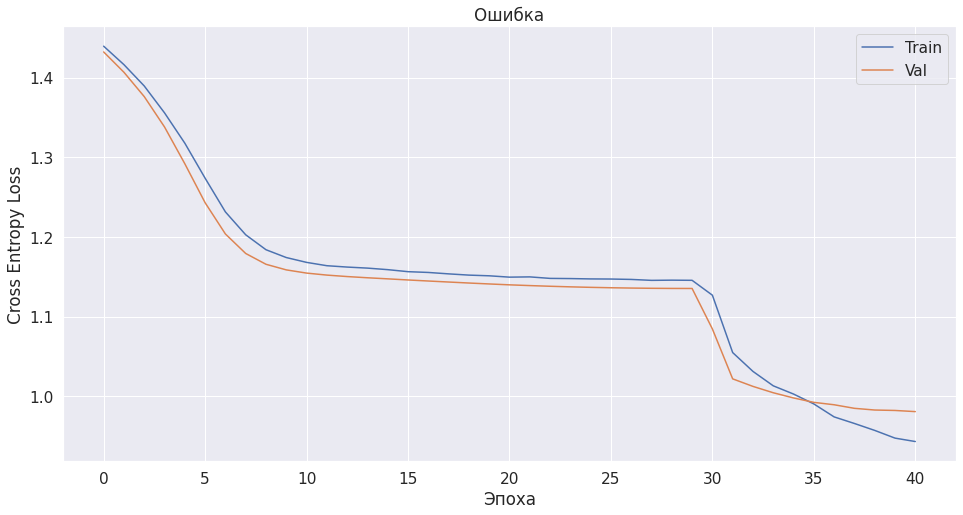

In [24]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Ошибка')
plt.xlabel('Эпоха')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.show()

In [0]:
torch.save(
    model_classifier.state_dict(), 
    '/content/drive/My Drive/NLP/dialog-sent/models/bert-base/entity-classifier-masked'
)

In [0]:
model_classifier.load_state_dict(
    torch.load(
        '/content/drive/My Drive/NLP/dialog-sent/models/bert-base/entity-classifier-masked'
    )
)

Посомтрим на точность:

In [25]:
test_dataloader = DataLoader(
    test_dataset, batch_size=100
)

current_test_loss_acc = 0
current_test_loss_f1 = 0
current_test_loss_f1_macro = 0

for text, y in test_dataloader:


    tokens = tokenizer.batch_encode_plus(
        text,
        pad_to_max_length=True,
        return_tensors='pt'
    )

    logits = model_classifier(
        tokens['input_ids'].cuda(),
        attention_mask=tokens['attention_mask'].cuda()    
    ).argmax(dim=1)
    
    preds = logits.cpu().detach().numpy()
    current_test_loss_acc += accuracy_score(y.numpy(), preds)
    current_test_loss_f1 += f1_score(y.numpy(), preds, average='weighted')
    current_test_loss_f1_macro += f1_score(y.numpy(), preds, average='macro')

print('Accuracy: ', current_test_loss_acc / len(test_dataloader))
print('F1_score_weighted: ', current_test_loss_f1 / len(test_dataloader))
print('F1_macro: ', current_test_loss_f1_macro / len(test_dataloader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy:  0.7848529411764708
F1_score_weighted:  0.7600637079509985
F1_macro:  0.5703123749432986


Этот подход также себя не оправдал